In [1]:
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# user_spec과 loan_result의 일부 열을 join하여 user의 application별 신청 여부를 가져온다.

loan_result = pd.read_csv("loan_result.csv")
user_spec = pd.read_csv("user_spec.csv")[['application_id','user_id']]
user_app=loan_result.groupby('application_id').max()[['is_applied']].join(user_spec,how="outer")

In [3]:
# user의 정보를 가져온다.

userlist = pd.read_csv('userlist.csv',index_col=0)

In [4]:
# is_applied 정보가 포함된 log에사 대출 조회와 관련된 event만 가져와, (대출 조회 성공은 1, 중도 종료는 0)으로 mapping한다.

alllog = pd.read_csv('alllog.csv')
alllog_app = alllog
alllog_app['appevent'] = alllog_app[
    alllog_app['event'].isin(
        ['ViewLoanApply','StartLoanApply',
        'CompleteIDCertification','IsApplied',
        'NotApplied']
    )
]['event'].map(
    {'ViewLoanApply':0,'StartLoanApply':0,
     'CompleteIDCertification':0,'IsApplied':1,
     'NotApplied':1}
)
alllog_app = alllog_app.dropna()[['user_id','appevent']]

In [5]:
# 전처리한 log에서 부가기능 사용 정보만 가져와 user별로 사용 횟수를 계산하여 전체 데이터에 feature로 추가

alllog_aux = pd.concat([alllog['user_id'], pd.get_dummies(alllog['event'])],axis=1)
alllog_aux = alllog_aux.groupby('user_id').sum()[['GetCreditInfo','UseDSRCalc','UsePrepayCalc','UseLoanManage']]
alllog_aux['user_id'] = alllog_aux.index
alllog_aux = alllog_aux.reset_index(drop = True)
fulllist = pd.merge(userlist,alllog_aux,on ='user_id')

In [6]:
# 대출성사비율 파생변수 생성하여 전체 데이터에 feature로 추가

app_rate = pd.DataFrame()
app_rate['app_rate'] = user_app.groupby('user_id').mean()['is_applied']
app_rate['app_count'] = user_app.groupby('user_id').count()['is_applied']
app_rate['user_id'] = user_app.groupby('user_id').count().index
app_rate = app_rate.reset_index(drop = True)
fulllist = pd.merge(fulllist,app_rate,on ='user_id')

In [8]:
# 조회완료비율 파생변수 생성하여 전체 데이터에 feature로 추가

finishrate = pd.DataFrame()
finishrate['finishrate'] = (alllog_app.groupby('user_id').sum()['appevent'])/(
    alllog_app.groupby('user_id').count()['appevent']-alllog_app.groupby(
        'user_id').sum()['appevent'])
finishrate['finishrate'] = finishrate['finishrate'].apply(lambda x: 1 if str(x)=='inf' else x)
finishrate['user_id'] = alllog_app.groupby('user_id').count().index
finishrate = finishrate.reset_index(drop = True)
fulllist = pd.merge(fulllist,finishrate,on ='user_id')

In [9]:
# session별로 log_data를 묶은 데이터를 가져와 각 user의 평균 session 길이, 총 시간, 본인인증 여부를 연산한다.

session = pd.read_csv("session.csv",)
session['sessionlength'] = pd.to_timedelta(session.sessionlength).dt.total_seconds()
session = session.drop(
    session[session['sessionlength']<=3].index
)
temp=session.groupby(['user_id']).count()
user_time=temp[['sessionnum']]

user_time['certificate'] = session.groupby(['user_id']).sum()['CompleteIDCertification'].apply(
    lambda x: 1 if x > 0 else 0
)
user_time['totaltime'] = session.groupby(['user_id']).sum()['sessionlength']
user_time['averagedur'] = user_time['totaltime']/user_time['sessionnum']
user_time['user_id'] = user_time.index
user_time = user_time.reset_index(drop = True)

<ipython-input-9-bffe5c8c337e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_time['certificate'] = session.groupby(['user_id']).sum()['CompleteIDCertification'].apply(
<ipython-input-9-bffe5c8c337e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_time['totaltime'] = session.groupby(['user_id']).sum()['sessionlength']
<ipython-input-9-bffe5c8c337e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [10]:
# 나머지 user 정보에 merge한다.

fulllist = pd.merge(
    fulllist,
    user_time[['user_id','sessionnum','averagedur','certificate']],
    on ='user_id'
)
fulllist = fulllist.dropna()

In [11]:
# 나이, 근속연수 열 추가 등 전처리

fulllist['age'] = pd.to_datetime(fulllist['birth_year']).apply(lambda x: 2022 - x.year)
fulllist['desired_amount'] = fulllist['desired_amount'].apply(lambda t: np.log10(t+1))
fulllist['yearly_income'] = fulllist['yearly_income'].apply(lambda t: np.log10(t+1))
fulllist['existing_loan_amt'] = fulllist['existing_loan_amt'].apply(lambda t: np.log10(t+1))
fulllist['seniority'] = pd.to_datetime(fulllist['company_enter_month']).apply(lambda x: 2022 - x.year)
fulllist = fulllist.drop(['index'],axis = 1)

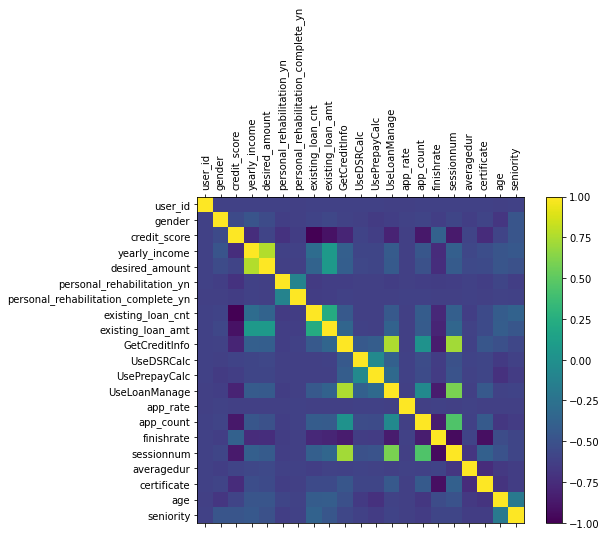

In [68]:
# 생성한 파생변수들 사이의 상관관계

corr = fulllist.corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax=ax.matshow(corr,vmin=-1,vmax=1)
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(rotation=90)
plt.colorbar(cax)

<AxesSubplot:>

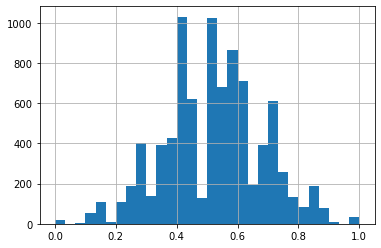

In [17]:
# 대출성사비율의 히스토그램

fulllist[(fulllist['app_count']>6) & (fulllist['app_rate']<=1)]['app_rate'].hist(bins = 30)

<AxesSubplot:xlabel='finishrate', ylabel='Density'>

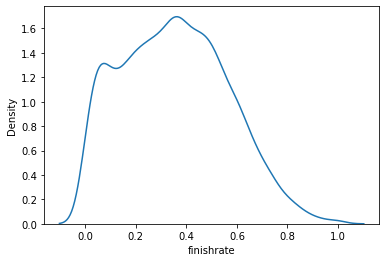

In [18]:
# 조회 완료비율의 분포를 알아보기 위해 히스토그램 대신 KDE plot을 그렸다.

sns.kdeplot(fulllist[(fulllist['app_count']>6) & (fulllist['finishrate']<=1)]['finishrate'])

In [42]:
# 사용자들의 본인 인증 (1.0 / 0/0) 의 평균이 0.665이므로
# 66.5%가 본인인증을 한번이라도 진행했고, 나머지 33.5%는 데이터 제공기간동안 본인인증을 진행하지 않았다.

user_time['certificate'].mean()

0.6651600906080604

<AxesSubplot:>

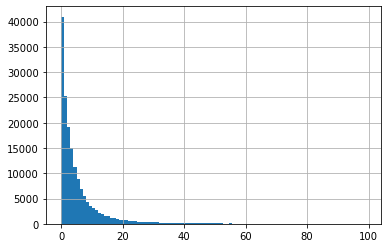

In [24]:
# 대출관리 부가기능 UseLoanManage의 사용자별 사용 빈도 히스토그램이다.

fulllist[fulllist['UseLoanManage']<100]['UseLoanManage'].hist(bins = 100)

In [49]:
# 대출관리 기능의 사용 빈도의 제3사분위수(상위25%값)를 구한다.

np.percentile(fulllist[fulllist['UseLoanManage']<100]['UseLoanManage'],75)

6.0

<AxesSubplot:>

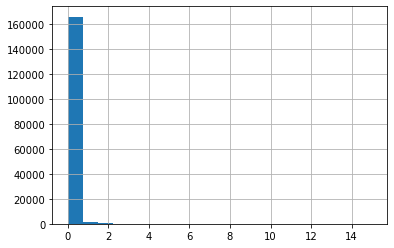

In [32]:
# 부가기능 UseDSRCalc의 사용자별 사용 빈도 히스토그램이다.

fulllist[fulllist['UseDSRCalc']<20]['UseDSRCalc'].hist(bins = 20)

<AxesSubplot:>

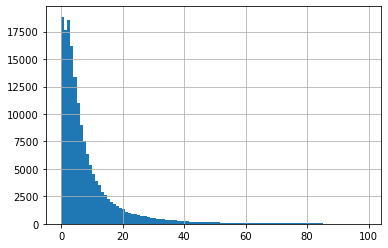

In [26]:
# 부가기능 GetCreditInfo의 사용자별 사용 빈도 히스토그램이다.

fulllist[fulllist['GetCreditInfo']<100]['GetCreditInfo'].hist(bins = 100)

In [50]:
# GetCreditInfo의 사용 빈도의 제3사분위수(상위25%값)를 구한다.

np.percentile(fulllist[fulllist['GetCreditInfo']<100]['GetCreditInfo'],75)

10.0

<AxesSubplot:>

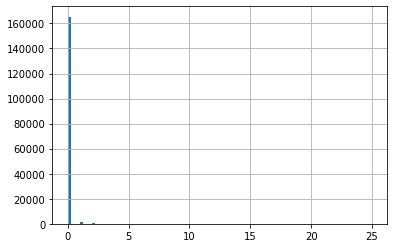

In [29]:
# 부가기능 UsePrepayCalc의 사용자별 사용 빈도 히스토그램이다.

fulllist[fulllist['UsePrepayCalc']<200]['UsePrepayCalc'].hist(bins = 100)

<AxesSubplot:>

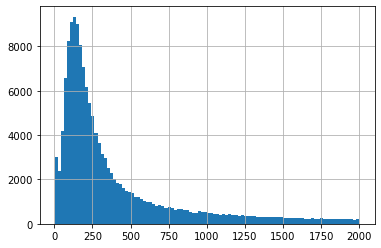

In [43]:
# 사용자별 평균 앱 접속시간(session의 평균 시간) 히스토그램이다.

fulllist[fulllist['averagedur']<2000]['averagedur'].hist(bins = 100)

<AxesSubplot:>

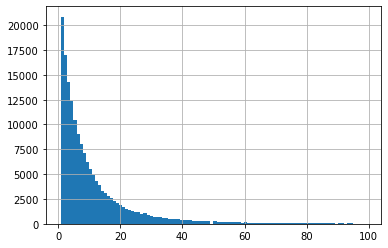

In [41]:
# 사용자별 앱 접속 횟수 히스토그램이다.

fulllist[fulllist['sessionnum']<100]['sessionnum'].hist(bins = 100)